# Projeto Final em Tópicos em Engenharia - 2024.1:

**Nome:** Gustavo de Paula Ávila

**Matrícula:** 212006871

# 1. Preparação do ambiente e importação das bibliotecas:

Montagem do drive, montagem do caminho para utils_exp2.py:

In [164]:
#allows the drive to be accessed
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [165]:
import sys

!cat '/content/drive/My Drive/TopEng/Projeto Final/utils_exp2.py'
sys.path.append('/content/drive/My Drive/TopEng/Projeto Final/')

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# Machine Learning Library
import torch

# work with math and erfc
import math
from scipy.special import erfc

from pylab import *
from sklearn.manifold import TSNE

# Função Q(x)
def func_q(x):
    return (1/2)*erfc((1/math.sqrt(2))*x)

# Detector ótimo para os esquemas tradicionais de modulação
def genareteBER(M, EbNodB_range):
    # gera o vetor de BER para cada uma das modulações tradicionais: M-ASK, M-PSK e M-QAM para 
    # uma dada lista de SNRs
    m_ask = [None]*len(EbNodB_range)
    m_psk = [None]*len(EbNodB_range)
    m_qam = [None]*len(EbNodB_range)
    for n in range(0,len(EbNodB_range)):
        EbNo=10.0**(EbNodB_range[n]/10.0)
        m_ask[n] = 2*(1-(1/M))*func_q((math.sqrt((6*math.log2(M))/(M**2-1)*EbNo)))
        m_psk[n] = 2*func_q(math.sin(math.pi/M)*math.sqrt(2*math.log2(M)*EbNo))
        

Importação das bibliotecas utilizadas e verificação da GPU:
(Código reutilizado do DP7)

In [166]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt
%matplotlib inline

# Optimization module in scipy
from scipy import optimize

# Machine Learning Library
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# work with math and erfc
import math
from scipy.special import erfc

# aditional modules for vizualisation
from pylab import *
from sklearn.manifold import TSNE

# complementary functions
import utils_exp2

In [167]:
train_on_gpu = torch.cuda.is_available() #Check if the GPU is available
if train_on_gpu: #if yes
    device = torch.device('cuda') #Select device as GPU
    print("Treinando na GPU.")
else:
    device = torch.device('cpu') #Select device as CPU
    print("GPU indisponível, treinando na CPU.")

GPU indisponível, treinando na CPU.


# Implementação do Autoencoder:
Código baseado em grande parte na implementação de Autoencoder no DP7, adicionando parametrização para facilitar a modularização.

In [168]:
class autoencoder(nn.Module):
    def __init__(self, M, n_channel, n_simbolos, R, module):
        self.k = math.sqrt(M)
        self.M = M
        self.n_channel = n_channel
        self.n_simbolos = n_simbolos

        self.module = module

        self.EbN0 = 0
        self.R = R

        self.learning_rate = 0
        self.num_epochs = 0
        self.batch_size = 0
        self.n_treino = 0

        n_net = n_simbolos*n_channel
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(M, n_net, bias=True),
            nn.ReLU(True),
            nn.Linear(n_net, n_net, bias=True),
            nn.BatchNorm1d(n_net, affine=True))
        self.decoder = nn.Sequential(
            nn.Linear(n_net, M, bias=True),
            nn.ReLU(True),
            nn.Linear(M, M, bias=True),
            nn.Softmax())

    def forward(self, x, R, n_channel, n_simbolos, EbN0):
        self.EbN0 = EbN0
        self.R = R
        outs = {}
        n_net = n_simbolos*n_channel
        x_size = x.shape[0]

        # Encoder Layer
        x = self.encoder(x)
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x*(math.sqrt(n_channel))

        outs['encoded'] = x

        noise_channel = torch.normal(0.0, math.sqrt(1/(2*R*(10.0**(EbN0/10.0)))),[x_size, n_net])
        x = x + noise_channel
        outs['encoded_noise'] = x

        # Decoder Layer
        x = self.decoder(x)
        outs['decoded'] = x
        return outs

    def auto_encoder(self, x, n_channel, n_simbolos):
        x = self.encoder(x)
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x*(math.sqrt(n_channel))
        return x

    def auto_decoder(self, x):
        x = self.decoder(x)
        return x

# Função de Treinamento:
Função de treinamento para o Autoencoder, com relação sinal-ruído (EbN0) configuravel fora da inicialização do modelo Autoencoder:

In [169]:
def AETrainingFunction(model, trainData, EbN0):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=model.learning_rate, weight_decay=1e-5)

  loss_epoch = []

  for epoch in range(model.num_epochs):
    dataloader = DataLoader(trainData, batch_size=model.batch_size, shuffle=True)

    for input_in in dataloader:
      output = model(input_in, model.R, model.n_channel, model.n_simbolos, EbN0)
      target_crossEntropy = torch.argmax(input_in, dim=-1).type(torch.LongTensor)
      loss = criterion(output['decoded'], target_crossEntropy)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    loss_epoch.append(loss.data)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, model.num_epochs, loss.data))

  return loss_epoch


# Função de Plotagem do Treino (Loss):
Fução para construção de gráfico de treino para o modelo, em relação ao Loss diante o número de épocas do treino. Utiliza o parametro loss_epoch obtido diante da função de treino:

In [170]:
def plotLoss(loss_epoch, model):
  vector_loss = np.arange(0,len(loss_epoch),1)
  fig = plt.figure(figsize=(10,8))
  plt.plot(vector_loss,loss_epoch,'b',label='Autoencoder(%d,%d)'%(model.n_channel, model.k))
  plt.xlabel('Epoca')
  plt.ylabel('Loss')
  plt.title('Loss por Época')
  plt.legend(loc='lower left',ncol = 1)
  plt.grid()
  plt.show()

# Função de Teste (SER – taxa de erro de símbolo):
Implementação de função de teste analisando a taxa de erro dos símbolos processados pelo autoencoder

In [171]:
def SER(n_teste, model, testData, EbN0):
  #Estabelecimento de "range" pra relação sinal-ruído
  EbNodB_range = torch.arange(0, 8, 0.5)
  ser = [None] * len(EbNodB_range)

  for n in range(len(EbNodB_range)):
      EbNo = 10.0 ** (EbNodB_range[n] / 10.0)
      noise_std = np.sqrt(1 / (2 * model.R * EbNo)).item()
      noise_mean = 0.0
      noise = torch.normal(noise_mean, noise_std, (n_teste, model.n_channel * model.n_simbolos))

      #Shuffle
      data = TensorDataset(testData, torch.LongTensor(test_label))
      dataloader_test = DataLoader(data, batch_size=n_teste, shuffle=True)

      #Data e labels de teste
      test_data_ = dataloader_test.dataset.tensors[0]
      label_ = np.array(dataloader_test.dataset.tensors[1])

      #Codificação de símbolo
      encoded_signal = model.auto_encoder(test_data_, model.n_channel, model.n_simbolos)

      #Influência por ruído
      channel_signal = encoded_signal + noise

      #Decodificação de simbolo
      pred_final_signal = model.auto_decoder(channel_signal)
      pred_output = torch.argmax(pred_final_signal, dim=-1).cpu().numpy()

      symbol_errors = np.sum(pred_output != label_)  #Contagem de erro de simbolos
      ser[n] = symbol_errors / n_teste  #Calculo de SER
      print('SNR:', EbNodB_range[n].item(), 'SER:', ser[n], 'Symbol Errors:', symbol_errors)

  return EbNodB_range, ser

# Função de resultado do encoder (espaço vetorial – complexo (2D)):
Função para montagem de gráfico para o teste-SER do auto-encoder implementado, e comparação com dados de modelação PSK e QAM já estabelecidas. , com relação sinal-ruído (EbN0) configuravel fora da inicialização do modelo Autoencoder. Utiliza a variável EbNodB_range e os valores obtidos em "ser" a partir da função de teste acima:

##**Definições**
##1. Modulação Phase Shift Keying (PSK)
  Modulação onde a fase de uma onda portadora é variada para representar dados digitais. Cada fase corresponde a um símbolo específico. Nesse sistema de modulação, quando há transição de nível de bit (entre 1 e 0), isso significa que a onda portadora sofre uma alteração de fase de 180°

##2. Quadrature Amplitude Modulation (QAM)
  Modulação em amplitude e fase. Varia tanto a amplitude quanto a fase da onda portadora para transmitir dados. Ajuda na obtenção de velocidades mais altas


In [172]:
def resultGraph(model, EbN0, EbNodB_range, ser):
  ask_M, psk_M, qam_M = utils_exp2.genareteBER(2**k, EbNodB_range)
  if model.module == 'QAM':
    fig = plt.figure(figsize=(10,8))
    fig_title = "Curvas de BLER para Autoencoder("+str(model.n_channel)+","+str(model.k)+")"
    plt.plot(EbNodB_range, qam_M, 'ko',label='TeoricoQAM')
    plt.plot(EbNodB_range, ser, 'bo',label='Autoencoder(%d,%d)'%(model.n_channel, model.k))
    plt.yscale('log')
    plt.xlabel('SNR Range')
    plt.ylabel('SER')
    plt.title(fig_title)
    plt.grid()
    plt.legend(loc='lower left',ncol = 1)
    plt.show()
  elif model.module == 'PSK':
    fig = plt.figure(figsize=(10,8))
    fig_title = "Curvas de BLER para Autoencoder("+str(model.n_channel)+","+str(model.k)+")"
    plt.plot(EbNodB_range, psk_M, 'ko',label='TeoricoPSK')
    plt.plot(EbNodB_range, ser, 'bo',label='Autoencoder(%d,%d)'%(model.n_channel, model.k))
    plt.yscale('log')
    plt.xlabel('SNR Range')
    plt.ylabel('SER')
    plt.title(fig_title)
    plt.grid()
    plt.legend(loc='lower left',ncol = 1)
    plt.show()

#Função de Definição dos Parâmetros de Treino:
Função para definir os parâmetros de treino nos modelos de autoencoder (learning rate, número de épocas, número de dados de treinamento, número de repetições pra treino):

In [173]:
def defineParams(model, learning_rate, num_epochs, batch_size):
  model.learning_rate = learning_rate
  model.num_epochs = num_epochs
  model.batch_size = batch_size * model.M
  model.n_treino = batch_size * 10


# Treinamento de Rede:
Treinamento e teste de 5 modelos, de acordo com o pedido nas especificações de atividade, utilizando as funções implementadas acima, com gráficos para comprovar a proximidade dos algorítimo de autoencoder de acordo com a modulação requisistada, e análise da função de custo (loss) no treinamento.

## 1. n = 1; k = 2; modulação PSK

In [174]:
n_channel = 1
k = 2
M = 2**k
R = k / n_channel
EbN0 = 7
module = "PSK"

# Transmisão de símbolos complexos (IQ)
#-- Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2

In [175]:
# Criação do Autoencoder (self, M, n_channel, n_simbolos, module)
model_1 = autoencoder(M, n_channel, n_simbolos, R, module)
print(model_1.M)
print(model_1.k)

4
2.0


In [176]:
defineParams(model_1, 0.1, 50, 10)  #defineParams(model, learning_rate, num_epochs, batch_size)
print(model_1.learning_rate)
print(model_1.num_epochs)
print(model_1.batch_size)
print(model_1.n_treino)

0.1
50
40
100


In [177]:
train_dataset = torch.eye(M)
trainData = train_dataset.repeat(int(model_1.n_treino/model_1.M),1)

loss_epoch = AETrainingFunction(model_1, trainData, EbN0)

epoch [1/50], loss:1.4014
epoch [2/50], loss:1.3660
epoch [3/50], loss:1.3096
epoch [4/50], loss:1.2208
epoch [5/50], loss:1.0320
epoch [6/50], loss:0.9051
epoch [7/50], loss:0.9137
epoch [8/50], loss:0.7724
epoch [9/50], loss:0.7795
epoch [10/50], loss:0.7521
epoch [11/50], loss:0.8080
epoch [12/50], loss:0.7916
epoch [13/50], loss:0.8012
epoch [14/50], loss:0.7658
epoch [15/50], loss:0.7985
epoch [16/50], loss:0.7451
epoch [17/50], loss:0.7874
epoch [18/50], loss:0.7473
epoch [19/50], loss:0.7547
epoch [20/50], loss:0.7864
epoch [21/50], loss:0.7439
epoch [22/50], loss:0.7686
epoch [23/50], loss:0.7458
epoch [24/50], loss:0.8562
epoch [25/50], loss:0.7740
epoch [26/50], loss:0.8667
epoch [27/50], loss:0.7934
epoch [28/50], loss:0.7982
epoch [29/50], loss:0.8636
epoch [30/50], loss:0.7552
epoch [31/50], loss:0.7441
epoch [32/50], loss:0.7494
epoch [33/50], loss:0.7534
epoch [34/50], loss:0.7449
epoch [35/50], loss:0.7538
epoch [36/50], loss:0.7809
epoch [37/50], loss:0.7628
epoch [38/

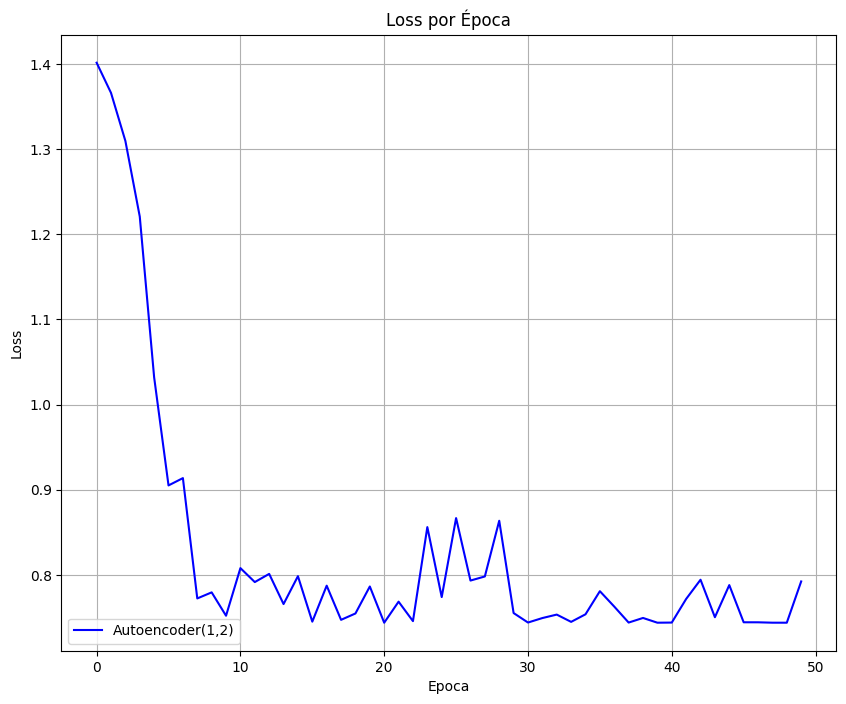

In [178]:
plotLoss(loss_epoch, model_1)

In [179]:

N_teste = 100000 * model_1.M
test_label = torch.randint(0, model_1.M, (N_teste,))
test_data = torch.nn.functional.one_hot(test_label).float()

EbN0dB_range, ser = SER(N_teste, model_1, test_data, EbN0) #SER(n_teste, model, EbN0) return EbNodB_range, ser

SNR: 0.0 SER: 0.15921 Symbol Errors: 63684
SNR: 0.5 SER: 0.1397125 Symbol Errors: 55885
SNR: 1.0 SER: 0.1184475 Symbol Errors: 47379
SNR: 1.5 SER: 0.0991325 Symbol Errors: 39653
SNR: 2.0 SER: 0.0818375 Symbol Errors: 32735
SNR: 2.5 SER: 0.067085 Symbol Errors: 26834
SNR: 3.0 SER: 0.0526275 Symbol Errors: 21051
SNR: 3.5 SER: 0.0401725 Symbol Errors: 16069
SNR: 4.0 SER: 0.0302875 Symbol Errors: 12115
SNR: 4.5 SER: 0.0221925 Symbol Errors: 8877
SNR: 5.0 SER: 0.015635 Symbol Errors: 6254
SNR: 5.5 SER: 0.0107 Symbol Errors: 4280
SNR: 6.0 SER: 0.0070525 Symbol Errors: 2821
SNR: 6.5 SER: 0.00473 Symbol Errors: 1892
SNR: 7.0 SER: 0.002755 Symbol Errors: 1102
SNR: 7.5 SER: 0.00145 Symbol Errors: 580


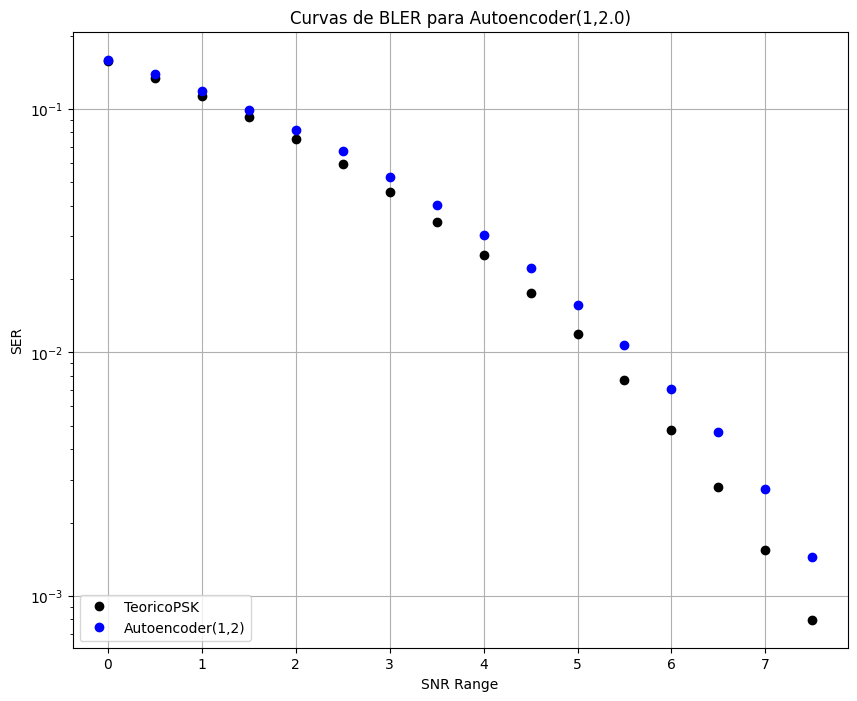

In [180]:
resultGraph(model_1, EbN0, EbN0dB_range, ser) #resultGraph(model, EbN0, EbNodB_range, ser)

## 2. n = 2; k = 2; modulação PSK

In [181]:
n_channel = 2
k = 2
M = 2**k
R = k / n_channel
EbN0 = 7
module = "PSK"

# Transmisão de símbolos complexos (IQ)
#-- Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2

In [182]:
# Criação do Autoencoder (self, M, n_channel, n_simbolos, module)
model_2 = autoencoder(M, n_channel, n_simbolos, R, module)
print(model_2.M)
print(model_2.k)

4
2.0


In [183]:
defineParams(model_2, 0.1, 50, 10)  #defineParams(model, learning_rate, num_epochs, batch_size)
print(model_2.learning_rate)
print(model_2.num_epochs)
print(model_2.batch_size)
print(model_2.n_treino)

0.1
50
40
100


In [184]:
train_dataset = torch.eye(model_2.M)
trainData = train_dataset.repeat(int(model_2.n_treino/model_2.M),1)

loss_epoch = AETrainingFunction(model_2, trainData, EbN0)

epoch [1/50], loss:1.3465
epoch [2/50], loss:1.1488
epoch [3/50], loss:0.9654
epoch [4/50], loss:0.9534
epoch [5/50], loss:0.8236
epoch [6/50], loss:0.8280
epoch [7/50], loss:0.7708
epoch [8/50], loss:0.8192
epoch [9/50], loss:0.8085
epoch [10/50], loss:0.7443
epoch [11/50], loss:0.7532
epoch [12/50], loss:0.7438
epoch [13/50], loss:0.7475
epoch [14/50], loss:0.7946
epoch [15/50], loss:0.7485
epoch [16/50], loss:0.7534
epoch [17/50], loss:0.7669
epoch [18/50], loss:0.8462
epoch [19/50], loss:0.7439
epoch [20/50], loss:0.7443
epoch [21/50], loss:0.7458
epoch [22/50], loss:0.7440
epoch [23/50], loss:0.7466
epoch [24/50], loss:0.8239
epoch [25/50], loss:0.7441
epoch [26/50], loss:0.7479
epoch [27/50], loss:0.7451
epoch [28/50], loss:0.7469
epoch [29/50], loss:0.7998
epoch [30/50], loss:0.8259
epoch [31/50], loss:0.7448
epoch [32/50], loss:0.7437
epoch [33/50], loss:0.7439
epoch [34/50], loss:0.7647
epoch [35/50], loss:0.7476
epoch [36/50], loss:0.7441
epoch [37/50], loss:0.8268
epoch [38/

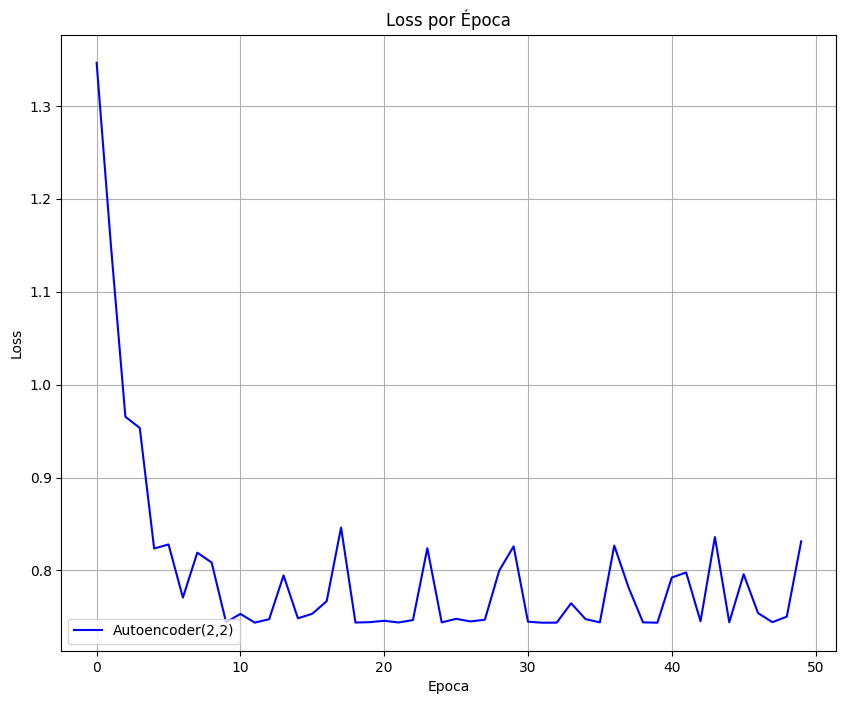

In [185]:
plotLoss(loss_epoch, model_2)

In [186]:

N_teste = 100000 * model_2.M
test_label = torch.randint(0, model_2.M, (N_teste,))
test_data = torch.nn.functional.one_hot(test_label).float()

EbN0dB_range, ser = SER(N_teste, model_2, test_data, EbN0) #SER(n_teste, model, EbN0) return EbNodB_range, ser

SNR: 0.0 SER: 0.17586 Symbol Errors: 70344
SNR: 0.5 SER: 0.1555775 Symbol Errors: 62231
SNR: 1.0 SER: 0.1350425 Symbol Errors: 54017
SNR: 1.5 SER: 0.1151875 Symbol Errors: 46075
SNR: 2.0 SER: 0.098205 Symbol Errors: 39282
SNR: 2.5 SER: 0.0831925 Symbol Errors: 33277
SNR: 3.0 SER: 0.068215 Symbol Errors: 27286
SNR: 3.5 SER: 0.0543525 Symbol Errors: 21741
SNR: 4.0 SER: 0.042835 Symbol Errors: 17134
SNR: 4.5 SER: 0.03379 Symbol Errors: 13516
SNR: 5.0 SER: 0.0254975 Symbol Errors: 10199
SNR: 5.5 SER: 0.01899 Symbol Errors: 7596
SNR: 6.0 SER: 0.0136575 Symbol Errors: 5463
SNR: 6.5 SER: 0.00969 Symbol Errors: 3876
SNR: 7.0 SER: 0.00674 Symbol Errors: 2696
SNR: 7.5 SER: 0.004575 Symbol Errors: 1830


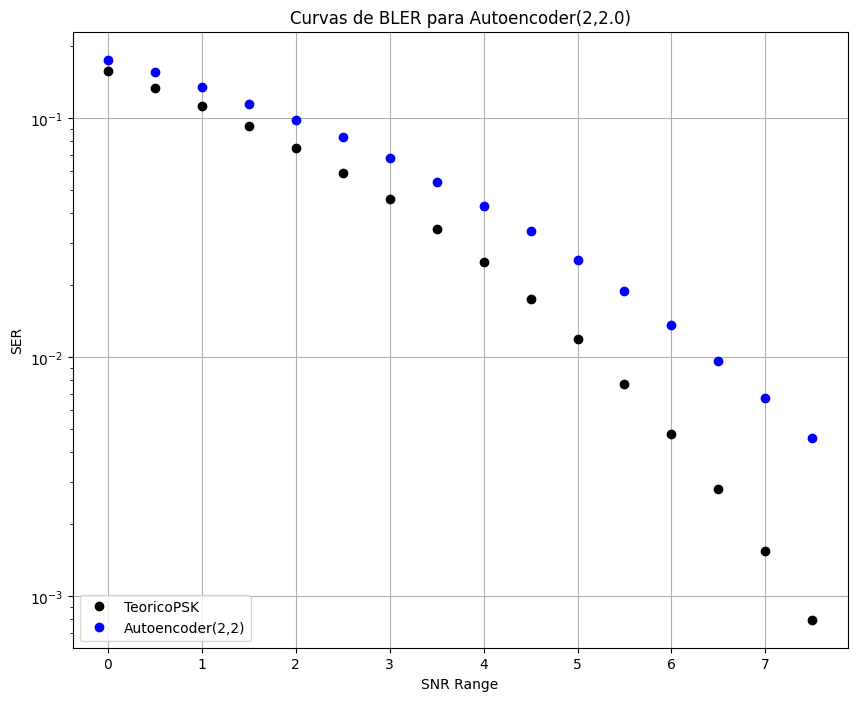

In [187]:
resultGraph(model_2, EbN0, EbN0dB_range, ser) #resultGraph(model, EbN0, EbNodB_range, ser)

## 3. n = 3; k = 2; modulação QAM

In [188]:
n_channel = 3
k = 2
M = 2**k
R = k / n_channel
EbN0 = 7
module = "QAM"

# Transmisão de símbolos complexos (IQ)
#-- Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2

In [189]:
# Criação do Autoencoder (self, M, n_channel, n_simbolos, module)
model_3 = autoencoder(M, n_channel, n_simbolos, R, module)
print(model_3.M)
print(model_3.k)

4
2.0


In [190]:
defineParams(model_3, 0.1, 50, 10)  #defineParams(model, learning_rate, num_epochs, batch_size)
print(model_3.learning_rate)
print(model_3.num_epochs)
print(model_3.batch_size)
print(model_3.n_treino)

0.1
50
40
100


In [191]:
train_dataset = torch.eye(model_3.M)
trainData = train_dataset.repeat(int(model_3.n_treino/model_3.M),1)

loss_epoch = AETrainingFunction(model_3, trainData, EbN0)

epoch [1/50], loss:1.2984
epoch [2/50], loss:1.0613
epoch [3/50], loss:1.1470
epoch [4/50], loss:1.1488
epoch [5/50], loss:1.0228
epoch [6/50], loss:0.9616
epoch [7/50], loss:0.9339
epoch [8/50], loss:0.8801
epoch [9/50], loss:0.8525
epoch [10/50], loss:0.7755
epoch [11/50], loss:0.7859
epoch [12/50], loss:0.8064
epoch [13/50], loss:0.8615
epoch [14/50], loss:0.7629
epoch [15/50], loss:0.7519
epoch [16/50], loss:0.7549
epoch [17/50], loss:0.7499
epoch [18/50], loss:0.7775
epoch [19/50], loss:0.7488
epoch [20/50], loss:0.7693
epoch [21/50], loss:0.9412
epoch [22/50], loss:0.7479
epoch [23/50], loss:0.7518
epoch [24/50], loss:0.8795
epoch [25/50], loss:0.7538
epoch [26/50], loss:0.7467
epoch [27/50], loss:0.7588
epoch [28/50], loss:0.7848
epoch [29/50], loss:0.7482
epoch [30/50], loss:0.7571
epoch [31/50], loss:0.7964
epoch [32/50], loss:0.8093
epoch [33/50], loss:0.7515
epoch [34/50], loss:0.8250
epoch [35/50], loss:0.7453
epoch [36/50], loss:0.7608
epoch [37/50], loss:0.7467
epoch [38/

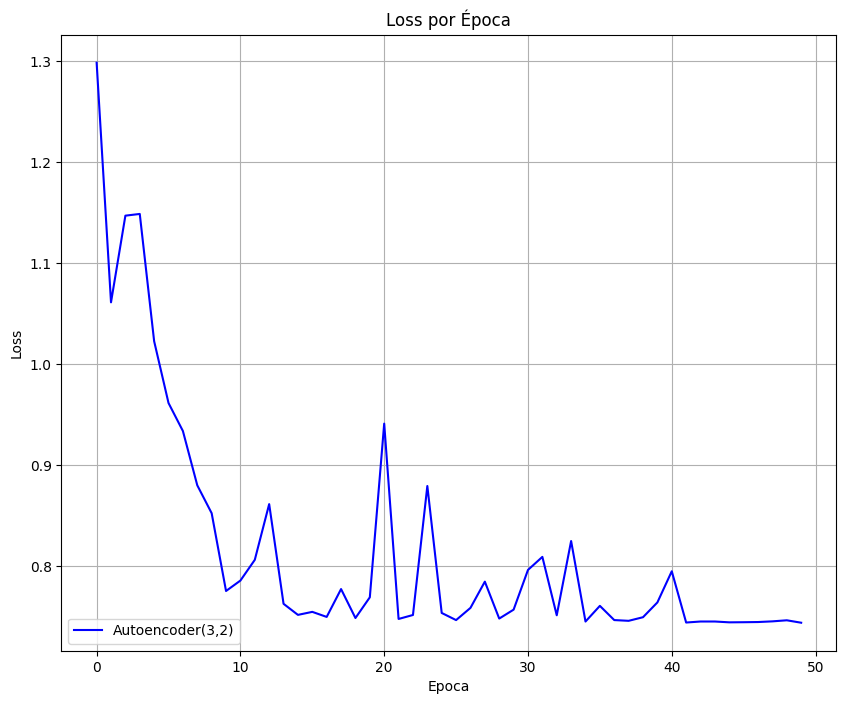

In [192]:
plotLoss(loss_epoch, model_3)

In [193]:

N_teste = 100000 * model_3.M
test_label = torch.randint(0, model_3.M, (N_teste,))
test_data = torch.nn.functional.one_hot(test_label).float()

EbN0dB_range, ser = SER(N_teste, model_3, test_data, EbN0) #SER(n_teste, model, EbN0) return EbNodB_range, ser

SNR: 0.0 SER: 0.1685425 Symbol Errors: 67417
SNR: 0.5 SER: 0.14923 Symbol Errors: 59692
SNR: 1.0 SER: 0.127575 Symbol Errors: 51030
SNR: 1.5 SER: 0.108725 Symbol Errors: 43490
SNR: 2.0 SER: 0.09044 Symbol Errors: 36176
SNR: 2.5 SER: 0.0754375 Symbol Errors: 30175
SNR: 3.0 SER: 0.0605475 Symbol Errors: 24219
SNR: 3.5 SER: 0.0474125 Symbol Errors: 18965
SNR: 4.0 SER: 0.036165 Symbol Errors: 14466
SNR: 4.5 SER: 0.0276075 Symbol Errors: 11043
SNR: 5.0 SER: 0.02003 Symbol Errors: 8012
SNR: 5.5 SER: 0.014085 Symbol Errors: 5634
SNR: 6.0 SER: 0.0100775 Symbol Errors: 4031
SNR: 6.5 SER: 0.006595 Symbol Errors: 2638
SNR: 7.0 SER: 0.0042325 Symbol Errors: 1693
SNR: 7.5 SER: 0.002615 Symbol Errors: 1046


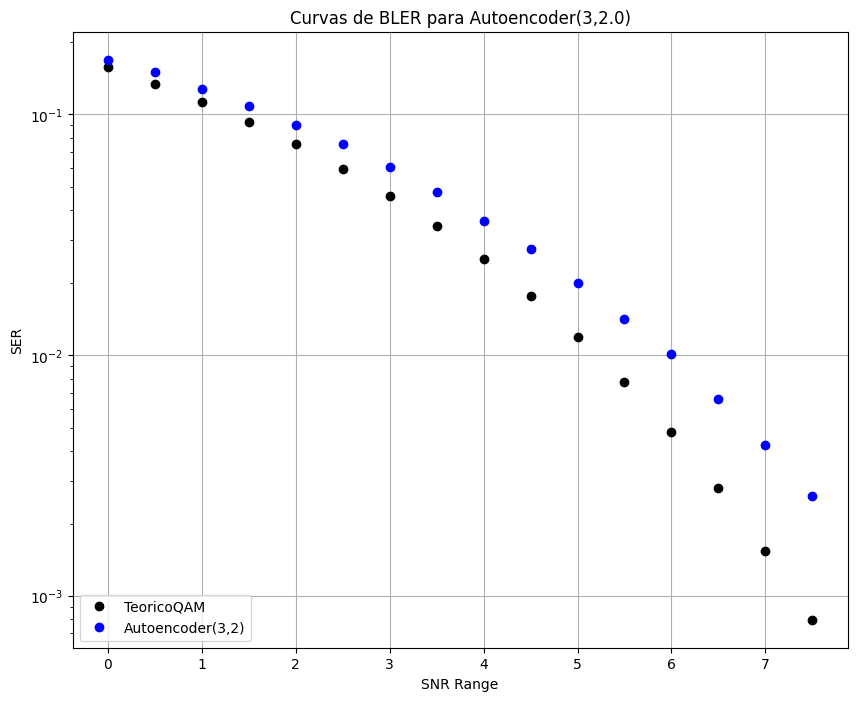

In [194]:
resultGraph(model_3, EbN0, EbN0dB_range, ser) #resultGraph(model, EbN0, EbNodB_range, ser)

## 4. n = 2; k = 3; modulação PSK

In [195]:
n_channel = 2
k = 3
M = 2**k
R = k / n_channel
EbN0 = 7
module = "PSK"

# Transmisão de símbolos complexos (IQ)
#-- Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2

In [196]:
# Criação do Autoencoder (self, M, n_channel, n_simbolos, module)
model_4 = autoencoder(M, n_channel, n_simbolos, R, module)
print(model_4.M)
print(model_4.k)

8
2.8284271247461903


In [197]:
defineParams(model_4, 0.1, 50, 10)  #defineParams(model, learning_rate, num_epochs, batch_size)
print(model_4.learning_rate)
print(model_4.num_epochs)
print(model_4.batch_size)
print(model_4.n_treino)

0.1
50
80
100


In [198]:
train_dataset = torch.eye(model_4.M)
trainData = train_dataset.repeat(int(model_4.n_treino/model_4.M),1)

loss_epoch = AETrainingFunction(model_4, trainData, EbN0)

epoch [1/50], loss:2.0713
epoch [2/50], loss:1.9953
epoch [3/50], loss:1.9159
epoch [4/50], loss:1.9148
epoch [5/50], loss:1.9908
epoch [6/50], loss:1.7603
epoch [7/50], loss:1.6227
epoch [8/50], loss:1.8034
epoch [9/50], loss:1.5782
epoch [10/50], loss:1.6848
epoch [11/50], loss:1.6091
epoch [12/50], loss:1.7960
epoch [13/50], loss:1.7142
epoch [14/50], loss:1.4987
epoch [15/50], loss:1.7928
epoch [16/50], loss:1.5504
epoch [17/50], loss:1.5954
epoch [18/50], loss:1.4299
epoch [19/50], loss:1.6180
epoch [20/50], loss:1.6323
epoch [21/50], loss:1.6409
epoch [22/50], loss:1.5256
epoch [23/50], loss:1.5076
epoch [24/50], loss:1.5953
epoch [25/50], loss:1.6033
epoch [26/50], loss:1.4679
epoch [27/50], loss:1.5881
epoch [28/50], loss:1.4839
epoch [29/50], loss:1.7974
epoch [30/50], loss:1.6512
epoch [31/50], loss:1.6914
epoch [32/50], loss:1.5856
epoch [33/50], loss:1.7137
epoch [34/50], loss:1.5267
epoch [35/50], loss:1.5269
epoch [36/50], loss:1.6128
epoch [37/50], loss:1.5213
epoch [38/

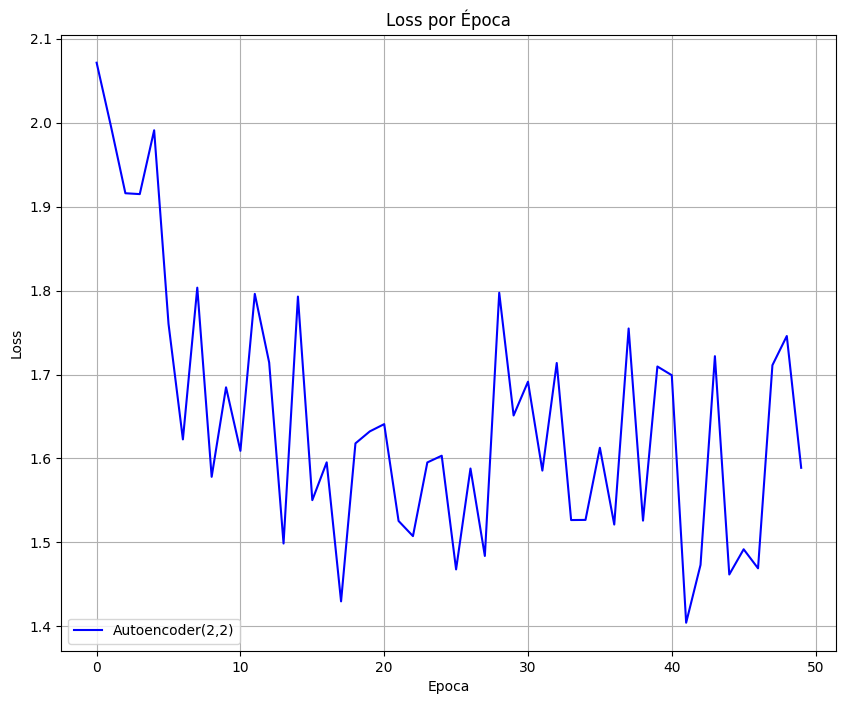

In [199]:
plotLoss(loss_epoch, model_4)

In [200]:

N_teste = 100000 * model_4.M
test_label = torch.randint(0, model_4.M, (N_teste,))
test_data = torch.nn.functional.one_hot(test_label).float()

EbN0dB_range, ser = SER(N_teste, model_4, test_data, EbN0) #SER(n_teste, model, EbN0) return EbNodB_range, ser

SNR: 0.0 SER: 0.4737375 Symbol Errors: 378990
SNR: 0.5 SER: 0.45929125 Symbol Errors: 367433
SNR: 1.0 SER: 0.44525125 Symbol Errors: 356201
SNR: 1.5 SER: 0.43133375 Symbol Errors: 345067
SNR: 2.0 SER: 0.41840125 Symbol Errors: 334721
SNR: 2.5 SER: 0.40567625 Symbol Errors: 324541
SNR: 3.0 SER: 0.39521625 Symbol Errors: 316173
SNR: 3.5 SER: 0.3837225 Symbol Errors: 306978
SNR: 4.0 SER: 0.373715 Symbol Errors: 298972
SNR: 4.5 SER: 0.3640975 Symbol Errors: 291278
SNR: 5.0 SER: 0.3557975 Symbol Errors: 284638
SNR: 5.5 SER: 0.34778875 Symbol Errors: 278231
SNR: 6.0 SER: 0.3400275 Symbol Errors: 272022
SNR: 6.5 SER: 0.33339 Symbol Errors: 266712
SNR: 7.0 SER: 0.3271625 Symbol Errors: 261730
SNR: 7.5 SER: 0.32137875 Symbol Errors: 257103


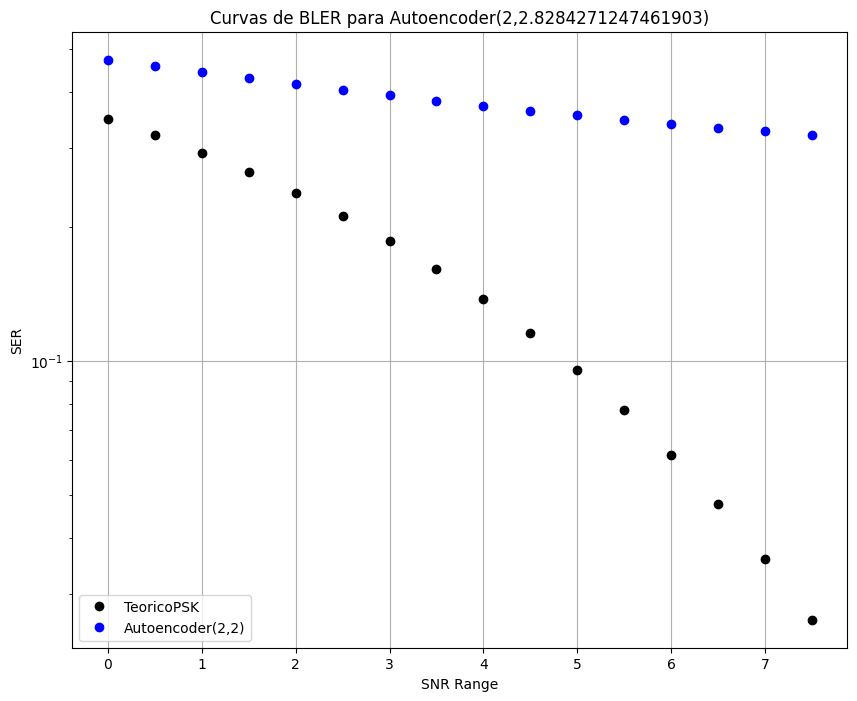

In [201]:
resultGraph(model_4, EbN0, EbN0dB_range, ser) #resultGraph(model, EbN0, EbNodB_range, ser)

**Único modelo que apresentou divergências significativas perante a implementação esperada.**

## 5. n = 2; k = 3; modulação QAM

In [202]:
n_channel = 2
k = 3
M = 2**k
R = k / n_channel
EbN0 = 7
module = "QAM"

# Transmisão de símbolos complexos (IQ)
#-- Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2

In [203]:
# Criação do Autoencoder (self, M, n_channel, n_simbolos, module)
model_5 = autoencoder(M, n_channel, n_simbolos, R, module)
print(model_5.M)
print(model_5.k)

8
2.8284271247461903


In [204]:
defineParams(model_5, 0.1, 50, 10)  #defineParams(model, learning_rate, num_epochs, batch_size)
print(model_5.learning_rate)
print(model_5.num_epochs)
print(model_5.batch_size)
print(model_5.n_treino)

0.1
50
80
100


In [205]:
train_dataset = torch.eye(model_5.M)
trainData = train_dataset.repeat(int(model_5.n_treino/model_5.M),1)

loss_epoch = AETrainingFunction(model_5, trainData, EbN0)

epoch [1/50], loss:2.0833
epoch [2/50], loss:1.9819
epoch [3/50], loss:1.8475
epoch [4/50], loss:1.8044
epoch [5/50], loss:1.9383
epoch [6/50], loss:1.7701
epoch [7/50], loss:1.6874
epoch [8/50], loss:1.8135
epoch [9/50], loss:1.6352
epoch [10/50], loss:1.6245
epoch [11/50], loss:1.6746
epoch [12/50], loss:1.5861
epoch [13/50], loss:1.4612
epoch [14/50], loss:1.4179
epoch [15/50], loss:1.5987
epoch [16/50], loss:1.5112
epoch [17/50], loss:1.5466
epoch [18/50], loss:1.6313
epoch [19/50], loss:1.4778
epoch [20/50], loss:1.5394
epoch [21/50], loss:1.3369
epoch [22/50], loss:1.4095
epoch [23/50], loss:1.3789
epoch [24/50], loss:1.5376
epoch [25/50], loss:1.3915
epoch [26/50], loss:1.2953
epoch [27/50], loss:1.2793
epoch [28/50], loss:1.3584
epoch [29/50], loss:1.4291
epoch [30/50], loss:1.2825
epoch [31/50], loss:1.4688
epoch [32/50], loss:1.3629
epoch [33/50], loss:1.4088
epoch [34/50], loss:1.3874
epoch [35/50], loss:1.3545
epoch [36/50], loss:1.4094
epoch [37/50], loss:1.4581
epoch [38/

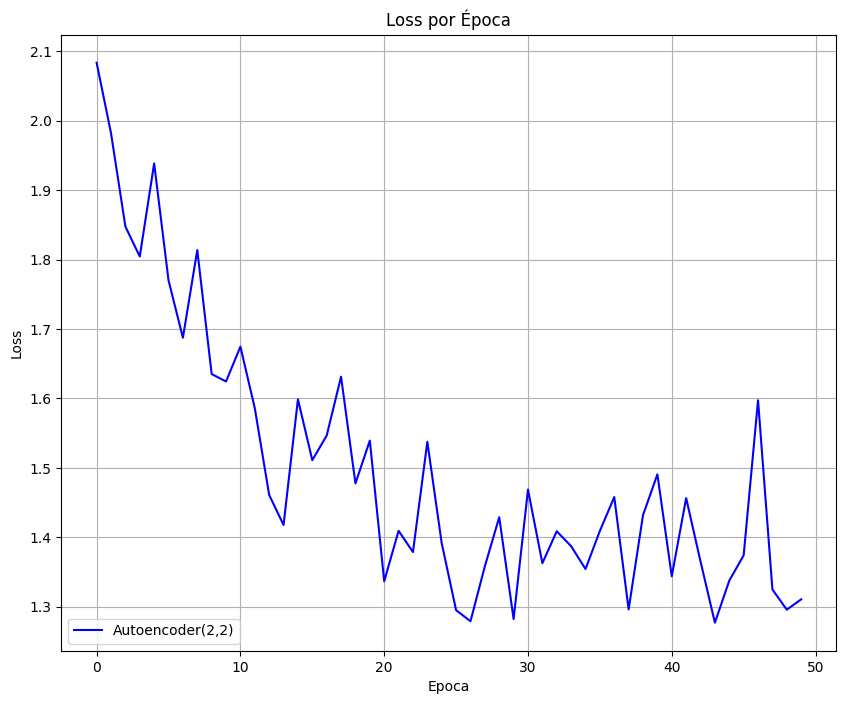

In [206]:
plotLoss(loss_epoch, model_5)

In [207]:

N_teste = 100000 * model_5.M
test_label = torch.randint(0, model_5.M, (N_teste,))
test_data = torch.nn.functional.one_hot(test_label).float()

EbN0dB_range, ser = SER(N_teste, model_5, test_data, EbN0) #SER(n_teste, model, EbN0) return EbNodB_range, ser

SNR: 0.0 SER: 0.28252125 Symbol Errors: 226017
SNR: 0.5 SER: 0.25378 Symbol Errors: 203024
SNR: 1.0 SER: 0.22715375 Symbol Errors: 181723
SNR: 1.5 SER: 0.201675 Symbol Errors: 161340
SNR: 2.0 SER: 0.17756375 Symbol Errors: 142051
SNR: 2.5 SER: 0.1542425 Symbol Errors: 123394
SNR: 3.0 SER: 0.13214375 Symbol Errors: 105715
SNR: 3.5 SER: 0.11243875 Symbol Errors: 89951
SNR: 4.0 SER: 0.0941225 Symbol Errors: 75298
SNR: 4.5 SER: 0.07856875 Symbol Errors: 62855
SNR: 5.0 SER: 0.06381 Symbol Errors: 51048
SNR: 5.5 SER: 0.05146875 Symbol Errors: 41175
SNR: 6.0 SER: 0.04107625 Symbol Errors: 32861
SNR: 6.5 SER: 0.03243375 Symbol Errors: 25947
SNR: 7.0 SER: 0.02529875 Symbol Errors: 20239
SNR: 7.5 SER: 0.01918375 Symbol Errors: 15347


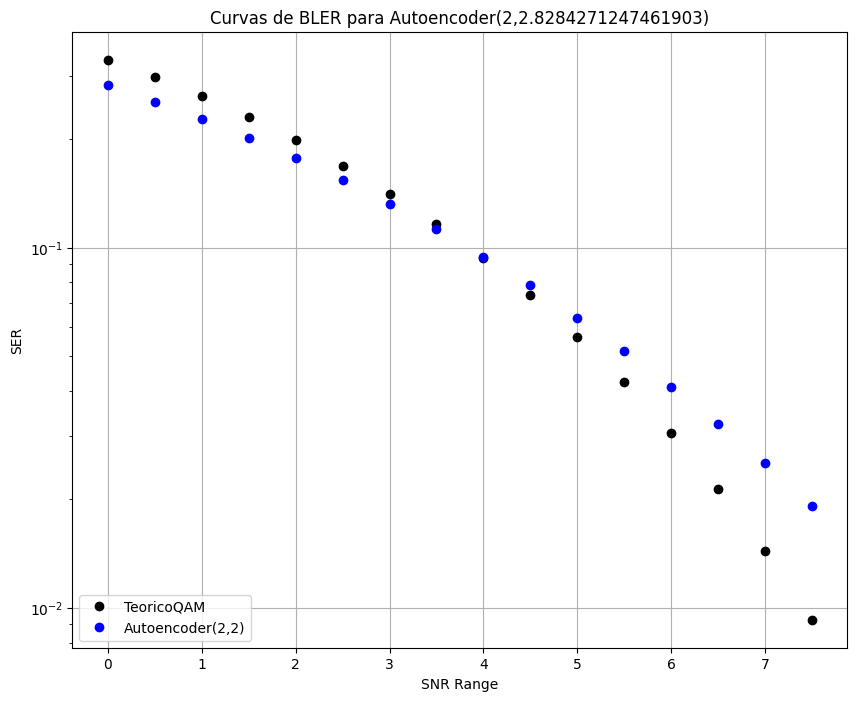

In [208]:
resultGraph(model_5, EbN0, EbN0dB_range, ser) #resultGraph(model, EbN0, EbNodB_range, ser)